<a href="https://colab.research.google.com/github/daisy-dotcom/ms_pacman/blob/main/ms_pacman_sac_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# run this cell once per Colab session
!apt update
!apt-get install xvfb x11-utils
!python -m pip install --upgrade swig
!python -m pip install --upgrade pyvirtualdisplay moviepy
!python -m pip install --upgrade gymnasium[accept-rom-license,atari,box2d,classic_control,mujoco,toy_text]
!python -m pip install torchinfo

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,031 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Ign:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,200 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu

In [ ]:
# import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from collections import deque
from pyvirtualdisplay import Display
import moviepy.editor as mpy
from torchinfo import summary
import ale_py

gym.register_envs(ale_py)
# create random number generator
rng = np.random.default_rng()

# create and start virtual display
display = Display(backend='xvfb')
display.start()

  if event.key is 'enter':



### Use GPU if available

In [ ]:
torch.get_default_device()

device(type='cpu')

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
  torch.set_default_device(torch.device(device))

torch.cuda.is_available()

True

In [ ]:
torch.get_default_device()

device(type='cuda', index=0)

In [ ]:
#seed = 4
#random.seed(seed)
#np.random.seed(seed)
#torch.manual_seed(seed)

#### Decorator to Add Functions to Classes

In [ ]:
# Register functions as methods
# in classes
def add_to_class(Class):
  def wrapper(obj):
    setattr(Class, obj.__name__, obj)
  return wrapper

### SAC Q-Network


In [ ]:
# SAC Q-network for approximating action-value function
class SACQNetwork(nn.Module):
    def __init__(self,
                 in_channels,
                 hidden_sizes,
                 output_size,
                 learning_rate):
        super().__init__()
        # create network layers
        layers = nn.ModuleList()

        # input layers
        layers.append(nn.Linear(in_channels, hidden_sizes[0]))
        layers.append(nn.ReLU())

        # hidden layers
        for i in range(len(hidden_sizes)-1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())


        # output layers
        # outputs a 1D tensor of size 1 with the Q value
        layers.append(nn.Linear(hidden_sizes[-1], output_size))


        # combine layers into feed-forward network
        self.net = nn.Sequential(*layers)

        # select loss function and optimizer
        # note: original paper uses modified MSE loss and RMSprop
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(),
                                          lr=learning_rate)

        # initialise the weights
        self.net.apply(self.init_weights)

    def init_weights(self, m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        # convert input to torch format
        if not torch.is_tensor(x):
            x = torch.tensor(x, dtype=torch.float)

        # return output of Q-network
        return self.net(x)

    def update(self, state, action, targets):
        # update network weights for a minibatch of inputs and targets:
        self.optimizer.zero_grad()
        outputs = self.forward(state)
        outputs = outputs.gather(1, action.long())
        loss = self.criterion(outputs, targets)
        loss.backward()
        self.optimizer.step()

    def copy_from(self, qnetwork):
        # copy weights from another Q-network
        self.net.load_state_dict(qnetwork.net.state_dict())

### Twin Q-Network

Source: Petros Christodoulou. (2019). Soft Actor Critic for Discrete Action Settings. https://arxiv.org/pdf/1910.07207

Petros Christodoulou. (2019). Deep Reinforcement Learning Algorithms with Pytorch SAC & SAC_Discrete. https://github.com/p-christ/Deep-Reinforcement-Learning-Algorithms-with-PyTorch/blob/master/agents/actor_critic_agents/SAC_Discrete.py

In [ ]:
class TwinQNetwork(nn.Module):
    def __init__(self, in_channels, hidden_sizes, output_size, learning_rate):
        super().__init__()
        # create twin network
        self.q1 = SACQNetwork(in_channels, hidden_sizes, output_size, learning_rate)
        self.q2 = SACQNetwork(in_channels, hidden_sizes, output_size, learning_rate)

    def forward(self, x):
        # return output of Q-network for the state + action input
        return self.q1(x), self.q2(x)

    def update(self, inputs, action, targets):
        # update network weights for a minibatch of inputs and targets:
        self.q1.update(inputs, action, targets)
        self.q2.update(inputs, action, targets)

    def copy_from(self, sac_qnetwork):
        # copy weights from another Q-network
        self.q1.copy_from(sac_qnetwork.q1)
        self.q2.copy_from(sac_qnetwork.q2)

### SAC Policy Network


In [ ]:
# Policy network for approximating policy function
# source: https://arxiv.org/pdf/1910.07207
class SACPolicyNetwork(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_sizes,
                 output_size,
                 learning_rate):
        super().__init__()
        # create network layers
        layers = nn.ModuleList()

        # input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())

        # hidden layers
        for i in range(len(hidden_sizes)-1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())

        # output layer (preferences/logits/unnormalised log-probabilities)
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        #layers.append(nn.Softmax(dim=1))

        # combine layers into feed-forward network
        self.net = nn.Sequential(*layers)

        # select optimizer
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=learning_rate)

        # initialise the weights
        self.net.apply(self.init_weights)

    def init_weights(self, m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        # convert input to torch format
        if not torch.is_tensor(x):
            x = torch.tensor(x, dtype=torch.float)
        # return output of policy network
        return self.net(x)

    def update(self, policy_loss):
        # update network weights for a given transition or trajectory
        self.optimizer.zero_grad()
        loss = policy_loss
        loss.backward()
        self.optimizer.step()

### Method To Obtain Action and Log Probabilities

Adds a small constant to the action probabilities so that all actions have a chance of being selected.

Source: Petros Christodoulou. (2019). Deep Reinforcement Learning Algorithms with Pytorch SAC & SAC_Discrete. https://github.com/p-christ/Deep-Reinforcement-Learning-Algorithms-with-PyTorch/blob/master/agents/actor_critic_agents/SAC_Discrete.py

In [ ]:
@add_to_class(SACPolicyNetwork)
def get_action_and_log_prob(self, state):
  logits = self.forward(state)
  dist = torch.distributions.Categorical(logits=logits)
  action_probs = dist.probs
  action = dist.sample()
  z = action_probs == 0
  z = z.float() * 1e-8
  log_pi = torch.log(action_probs + z)
  return action, action_probs, log_pi

### SAC Agent
#### Training Steps
*Initialise online networks*
<br>
*Initialise target networks*
<br>
*Equalise target and online network weights*
<br>
*Create and empty replay buffer*
<br>

for each iteration do

&emsp;for each environment step do

&emsp;&emsp; *Sample action from the policy*

&emsp;&emsp; *Sample transition from the environment*

&emsp;&emsp; *Store the transition in the replay buffer*

&emsp;for each gradient step do

&emsp;&emsp; *Update the online Q function parameters*

&emsp;&emsp; *Update the policy weights*

&emsp;&emsp; *Update the temperature/alpha/entropy coefficient*

&emsp;&emsp; *Update the target network weights after a specified number of steps*


Source: Petros Christodoulou. (2019). Soft Actor Critic for Discrete Action Settings. https://arxiv.org/pdf/1910.07207

Petros Christodoulou. (2019). Deep Reinforcement Learning Algorithms with Pytorch SAC & SAC_Discrete. https://github.com/p-christ/Deep-Reinforcement-Learning-Algorithms-with-PyTorch/blob/master/agents/actor_critic_agents/SAC_Discrete.py

In [ ]:
from os import stat_result
# source: https://github.com/p-christ/Deep-Reinforcement-Learning-Algorithms-with-PyTorch/blob/master/agents/actor_critic_agents/SAC_Discrete.py
class SAC():
    def __init__(self,
                 env,
                 gamma,
                 hidden_sizes=(32, 32),
                 replay_size=10000,
                 minibatch_size=32,
                 actor_learning_rate=0.001,
                 critic_learning_rate=0.005,
                 target_update=20,
                 warmup_target=100,
                 training_ep_per_eval=4,
                 target_entropy_ratio=0.98,
                 optim_time=4):

        # check if the state space has correct type
        #continuous = isinstance(env.observation_space, spaces.Box) and len(env.observation_space.shape) == 1
        #assert continuous, 'Observation space must be continuous with shape (n,)'
        self.state_dims = env.observation_space.shape[0]

        # check if the action space has correct type
        assert isinstance(env.action_space, spaces.Discrete), 'Action space must be discrete'
        self.num_actions = env.action_space.n

        # create critic networks
        self.online_critic = TwinQNetwork(self.state_dims, hidden_sizes, self.num_actions, critic_learning_rate)
        self.target_critic = TwinQNetwork(self.state_dims, hidden_sizes, self.num_actions, critic_learning_rate)

        self.target_critic.copy_from(self.online_critic)

        # create policy network
        self.actor = SACPolicyNetwork(self.state_dims, hidden_sizes, self.num_actions, actor_learning_rate)

        # replay buffer
        self.replay_buffer = deque(maxlen=replay_size)
        self.minibatch_size = minibatch_size

        # automatic entropy tuning
        self.target_entropy = target_entropy_ratio * -np.array(-np.log(1.0/self.num_actions), dtype=np.float32)
        self.log_entropy_coef = torch.zeros(1, requires_grad=True)
        self.entropy_optim = torch.optim.Adam([self.log_entropy_coef], lr=actor_learning_rate)
        self.entropy_coef = self.log_entropy_coef.exp()

        # optimization & evaluation
        self.optim_time = optim_time
        self.warmup_target = warmup_target
        self.training_ep_per_eval = training_ep_per_eval
        self.target_update = target_update
        self.target_update_idx = 0

        self.env = env
        self.gamma = gamma


    def train(self, max_episodes, stop_criterion, criterion_episodes):
        # train the agent for a number of episodes
        self.num_steps = 0

        episode_rewards = []
        training_rewards = []
        for episode in range(max_episodes):
            steps = 0
            state, _ = self.env.reset()

            # convert state to torch format
            #state = torch.tensor(state, dtype=torch.float)
            terminated = False
            truncated = False


            rewards = []
            trajectory = []
            eval_ep = episode % self.training_ep_per_eval == 0
            if eval_ep:
              episode_rewards.append(0)
            else:
              training_rewards.append(0)


            # generate trajectory
            while not (terminated or truncated):
                # select action by following policy
                action = self.policy(state, eval=eval_ep)

                # send the action to the environment
                next_state, reward, terminated, truncated, _  = self.env.step(action)

                rewards.append(reward)
                if eval_ep:
                  episode_rewards[-1] += reward
                else:
                  training_rewards[-1] += reward

                is_failure = terminated and not truncated

                # add transition to trajectory
                if not eval_ep:
                  self.replay_buffer.append((state,
                                            action,
                                            reward,
                                            next_state,
                                            float(is_failure)))



                state = next_state
                self.num_steps += 1
                steps += 1

                # update policy & online critic networks after warming up,
                # if there are enough samples in the replay buffer and
                # at every 4th step
                done_warmup = self.num_steps > self.warmup_target
                enough_exp = len(self.replay_buffer) >= self.minibatch_size
                optimization_time = self.num_steps % self.optim_time == 0
                if (done_warmup and enough_exp and optimization_time):
                  self.update()

            if eval_ep:
              print(f'\rEpisode {episode+1} done: steps = {self.num_steps}, '
                    f'rewards = {np.sum(rewards)}', end='')

            else:
              print(f'\r Training Episode {episode+1} done: steps = {self.num_steps}, '
                    f'rewards = {np.sum(rewards)}', end='')

            if episode >= criterion_episodes-1 and stop_criterion(episode_rewards[-criterion_episodes:]):
                print(f'\nStopping criterion satisfied after {episode} episodes')
                break

        # plot rewards received during training & evaluation
        plt.figure(dpi=100)
        plt.plot(range(1, len(episode_rewards)+1), episode_rewards, label=f'Rewards')

        plt.xlabel('Eval Episodes')
        plt.ylabel('Rewards per episode')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

        plt.figure(dpi=100)
        plt.plot(range(1, len(training_rewards)+1), training_rewards, label=f'Rewards')

        plt.xlabel('Training Episodes')
        plt.ylabel('Rewards per episode')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

    def copy_from(self, policynet):
       # copy weights from another Q-network
       self.net.copy_from(policynet)

    def save(self, path):
        # save network weights to a file
        torch.save(self.policynet.state_dict(), path)

    def load(self, path):
        # load network weights from a file
        self.policynet.load_state_dict(torch.load(path))

### Modified Policy Method to Stop Gradient Update During Evaluation Episodes

Source: Petros Christodoulou. (2019). Deep Reinforcement Learning Algorithms with Pytorch SAC & SAC_Discrete. https://github.com/p-christ/Deep-Reinforcement-Learning-Algorithms-with-PyTorch/blob/master/agents/actor_critic_agents/SAC_Discrete.py

In [ ]:
@add_to_class(SAC)
def policy(self, state, stochastic=True, eval=False):
    # convert state to torch format
    if not torch.is_tensor(state):
        state = torch.tensor(state, dtype=torch.float)

    # calculate action probabilities
    if not eval:
      logits = self.actor(state).detach()
    else:
      with torch.no_grad():
        logits = self.actor(state).detach()

    dist = torch.distributions.Categorical(logits=logits)
    if stochastic:
        # sample action using action probabilities
        return dist.sample().item()
    else:
        # select action with the highest probability
        # note: we ignore breaking ties randomly (low chance of happening)
        return dist.probs.argmax().item()

### Randomly Sample Experiences from the Replay Buffer

Source: Petros Christodoulou. (2019). Deep Reinforcement Learning Algorithms with Pytorch - Data Structures - Replay Buffer. https://github.com/p-christ/Deep-Reinforcement-Learning-Algorithms-with-PyTorch/blob/master/utilities/data_structures/Replay_Buffer.py

In [ ]:
@add_to_class(SAC)
def get_experiences(self):
  batch = rng.choice(len(self.replay_buffer), size=self.minibatch_size, replace=False)

  replay_state = np.zeros((self.minibatch_size, self.state_dims))
  replay_action = np.zeros((self.minibatch_size, 1))
  replay_reward = np.zeros((self.minibatch_size, 1))
  replay_next_state = np.zeros((self.minibatch_size, self.state_dims))
  is_failure = np.zeros((self.minibatch_size, 1))

  i = 0
  for row in batch:
    replay_state[i] = self.replay_buffer[row][0]
    replay_action[i] = self.replay_buffer[row][1]
    replay_reward[i] = self.replay_buffer[row][2]
    replay_next_state[i] = self.replay_buffer[row][3]
    is_failure[i] = self.replay_buffer[row][4]
    i += 1

  replay_state = torch.tensor(replay_state, dtype=torch.float)
  replay_action = torch.tensor(replay_action, dtype=torch.float)
  replay_reward = torch.tensor(replay_reward, dtype=torch.float)
  replay_next_state = torch.tensor(replay_next_state, dtype=torch.float)
  is_failure = torch.tensor(is_failure, dtype=torch.float)

  return replay_state, replay_action, replay_reward, replay_next_state, is_failure

### Update the Networks

Update the policy network by minimizing the negative policy loss/objective

<br>

$J(α) = \pi_{t}(s_t)^{T} [-\alpha(log(\pi_{t}(s_t)) + \bar{H})]$

<br>

Update the online Q network using the minimum value of the next state-action pair obtained from the target twin Q network to compute the SAC target.
<br>

$SAC^{target} = r + γ [minQ(s',\hat{a}';\theta^{n,-}) - \alpha logπ(\hat{a}'|s';𝜙)]$

<br>

Automatically tune the entropy coefficient to reduce the number of hyperparameters to tune by minimizing the following objective for alpha where H is the target entropy.

<br>

$J(α) = - [α(H + logπ(\hat{a}|s;𝝓))]$

<br>

Source:
Miguel Morales. (2020). Grokking Deep Reinforcement Learning. Chapter 12 Advanced actor-critic methods

Petros Christodoulou. (2019). Soft Actor Critic for Discrete Action Settings. https://arxiv.org/pdf/1910.07207

Petros Christodoulou. (2019). Deep Reinforcement Learning Algorithms with Pytorch SAC & SAC_Discrete. https://github.com/p-christ/Deep-Reinforcement-Learning-Algorithms-with-PyTorch/blob/master/agents/actor_critic_agents/SAC_Discrete.py

In [ ]:
@add_to_class(SAC)
def update(self):
  # unpack trajectory
  replay_state, replay_action, replay_reward, replay_next_state, is_failure = self.get_experiences()

  with torch.no_grad():
    action, next_action_probs, next_log_pi = self.actor.get_action_and_log_prob(replay_next_state)

    next_target_q1, next_target_q2 = self.target_critic(replay_next_state)

    # get min Q values from target network
    min_next_q = torch.min(next_target_q1, next_target_q2)

    min_next_target_q = next_action_probs * (min_next_q - self.entropy_coef * next_log_pi)
    min_next_target_q = min_next_target_q.sum(dim=1, keepdim=True)

    next_q = replay_reward + (1.0 - is_failure) * self.gamma * min_next_target_q

  # update online critic
  self.online_critic.update(replay_next_state, replay_action, next_q)

  # calculate policy loss - actor
  # get q-value estimates of visited states
  q1, q2 = self.online_critic(replay_state)
  min_q = torch.min(q1, q2)

  action, action_probs, log_pi = self.actor.get_action_and_log_prob(replay_state)

  policy_loss = action_probs * ((self.entropy_coef * log_pi)  - min_q)
  policy_loss = policy_loss.sum(dim=1).mean()

  # entropy tuning
  entropy_loss = -(self.log_entropy_coef * (log_pi + self.target_entropy).detach()).mean()

  # update actor
  self.actor.update(policy_loss)

  # update entropy
  self.entropy_optim.zero_grad()
  entropy_loss.backward()
  self.entropy_optim.step()
  self.entropy_coef = self.log_entropy_coef.exp().detach()

  # update target critic network
  self.target_update_idx += 1
  if self.target_update_idx % self.target_update == 0:
    self.target_critic.copy_from(self.online_critic)

### Test Implementation on Acrobot Env

Episode 996 done: Total steps = 494810, rewards = -500.0

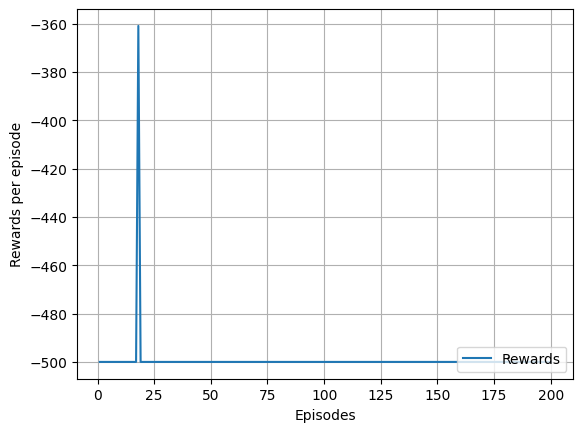

In [ ]:
# create the acrobot environment
env = gym.make('Acrobot-v1', render_mode="rgb_array_list")

gamma = 0.99
hidden_sizes = (64, 64, 64)
actor_learning_rate = 0.001
critic_learning_rate = 0.005
replay_size = 10000
minibatch_size = 64
target_update = 8000
training_ep_per_eval = 5
warmup_target = 20000
target_entropy_ratio = 0.9
optim_time = 4
max_episodes = 1000
max_steps = 18000
criterion_episodes = 5

agent = SAC(env,
            gamma=gamma,
            hidden_sizes=hidden_sizes,
            actor_learning_rate=actor_learning_rate,
            critic_learning_rate=critic_learning_rate,
            replay_size=replay_size,
            minibatch_size=minibatch_size,
            target_update=target_update,
            training_ep_per_eval=training_ep_per_eval,
            warmup_target = warmup_target,
            target_entropy_ratio=target_entropy_ratio,
            optim_time=optim_time)


agent.train(max_episodes, lambda x : min(x) >= -150, criterion_episodes)


In [ ]:
# visualise one episode
state, _ = env.reset()
terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated or steps > max_steps):
    # take action based on policy
    with torch.no_grad():
      action = agent.policy(state, stochastic=False)

    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    #print(f'Reward: {reward}')
    total_reward += reward
    steps += 1

print(f'Reward: {total_reward}')

# store RGB frames for the entire episode
frames = env.render()

# close the environment
env.close()

# create and play video clip using the frames and given fps
clip = mpy.ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

Reward: -224.0


### MsPacman

#### Initial Hyperparamters Set Using Petros Christodoulou's Hyperparameters in Soft Actor Critic for Discrete Action Settings.

* Batch size - 64
* Replay buffer size - 1,000,000
* Discount - 0.99
* Learning Rate - 0.0003
* Initial Warmup - 20,000
* Entropy Target - 0.98 * (-log(1/|A|))
* Fixed Network Update Frequency - 8,000
* Steps per Learning Update - 4

Source: Petros Christodoulou. (2019). Soft Actor Critic for Discrete Action Settings. https://arxiv.org/pdf/1910.07207

 Training Episode 1000 done: steps = 727374, rewards = 210.0

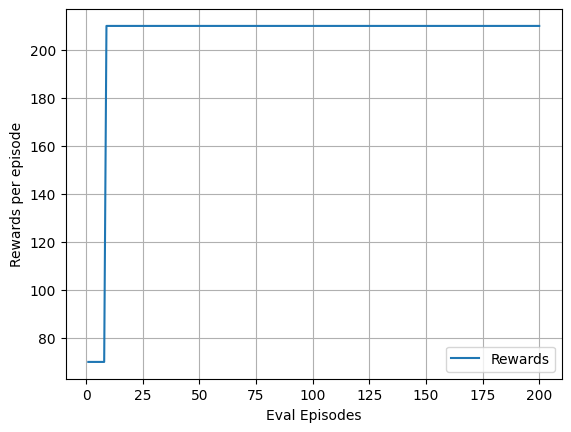

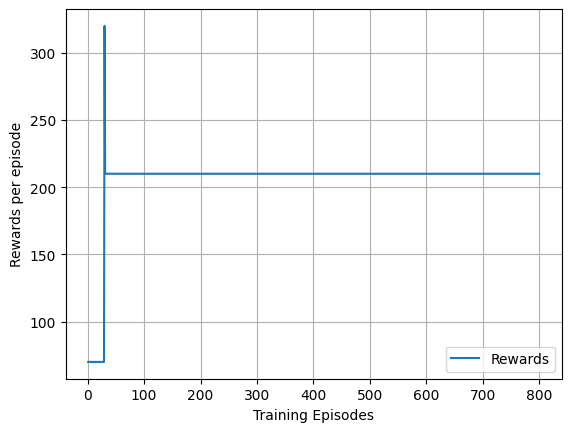

In [ ]:
# create the acrobot environment
env = gym.make('ALE/MsPacman-ram-v5', render_mode="rgb_array_list")

gamma = 0.99
hidden_sizes = (64, 64, 64)
actor_learning_rate = 0.003
critic_learning_rate = 0.003
replay_size = 1000000
minibatch_size = 64
target_update = 8000
training_ep_per_eval = 5
warmup_target = 20000
target_entropy_ratio = 0.98
optim_time = 4
max_episodes = 1000
max_steps = 18000
criterion_episodes = 5

agent = SAC(env,
            gamma=gamma,
            hidden_sizes=hidden_sizes,
            actor_learning_rate=actor_learning_rate,
            critic_learning_rate=critic_learning_rate,
            replay_size=replay_size,
            minibatch_size=minibatch_size,
            target_update=target_update,
            training_ep_per_eval=training_ep_per_eval,
            warmup_target = warmup_target,
            target_entropy_ratio=target_entropy_ratio,
            optim_time=optim_time)


agent.train(max_episodes, lambda x : min(x) >= 1000, criterion_episodes)


In [ ]:
# visualise one episode
state, _ = env.reset()
terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated or steps > max_steps):
    # take action based on policy
    with torch.no_grad():
      action = agent.policy(state, stochastic=False)

    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    #print(f'Reward: {reward}')
    total_reward += reward
    steps += 1

print(f'Reward: {total_reward}')

# store RGB frames for the entire episode
frames = env.render()

# close the environment
env.close()

# create and play video clip using the frames and given fps
clip = mpy.ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

Reward: 210.0


## Reduce Target Update
8000 to 4000

 Training Episode 1000 done: steps = 735000, rewards = 210.0

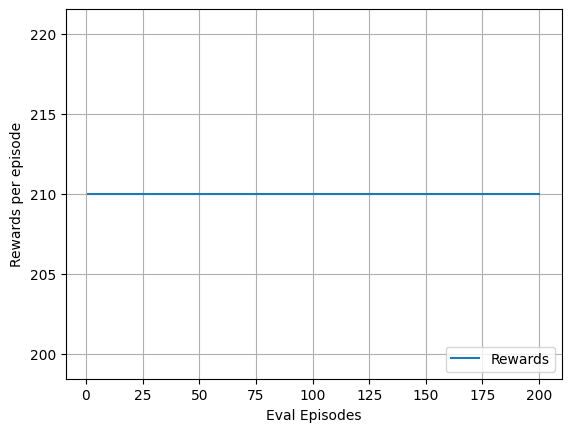

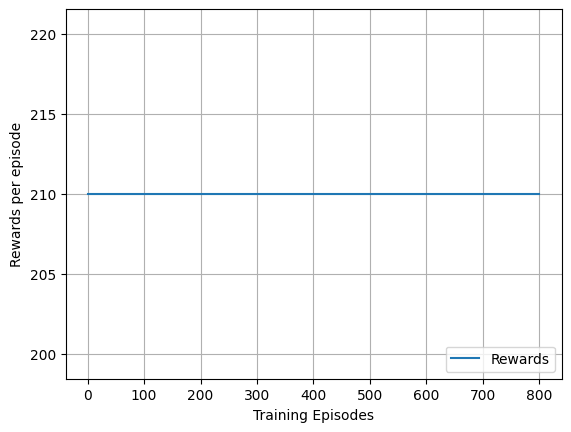

In [ ]:
# create the acrobot environment
env = gym.make('ALE/MsPacman-ram-v5', render_mode="rgb_array_list")

gamma = 0.99
hidden_sizes = (64, 64, 64)
actor_learning_rate = 0.003
critic_learning_rate = 0.003
replay_size = 1000000
minibatch_size = 64
target_update = 4000
training_ep_per_eval = 5
warmup_target = 20000
target_entropy_ratio = 0.98
optim_time = 4
max_episodes = 1000
max_steps = 18000
criterion_episodes = 5

agent = SAC(env,
            gamma=gamma,
            hidden_sizes=hidden_sizes,
            actor_learning_rate=actor_learning_rate,
            critic_learning_rate=critic_learning_rate,
            replay_size=replay_size,
            minibatch_size=minibatch_size,
            target_update=target_update,
            training_ep_per_eval=training_ep_per_eval,
            warmup_target = warmup_target,
            target_entropy_ratio=target_entropy_ratio,
            optim_time=optim_time)


agent.train(max_episodes, lambda x : min(x) >= 1000, criterion_episodes)


In [ ]:
# visualise one episode
state, _ = env.reset()
terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated or steps > max_steps):
    # take action based on policy
    with torch.no_grad():
      action = agent.policy(state, stochastic=False)

    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    #print(f'Reward: {reward}')
    total_reward += reward
    steps += 1

print(f'Reward: {total_reward}')

# store RGB frames for the entire episode
frames = env.render()

# close the environment
env.close()

# create and play video clip using the frames and given fps
clip = mpy.ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

Reward: 210.0


## Increase Minibatch Size
64 to 4096

 Training Episode 1000 done: steps = 486694, rewards = 60.0

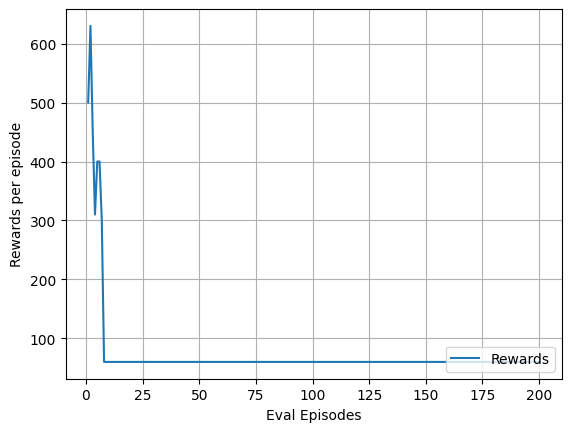

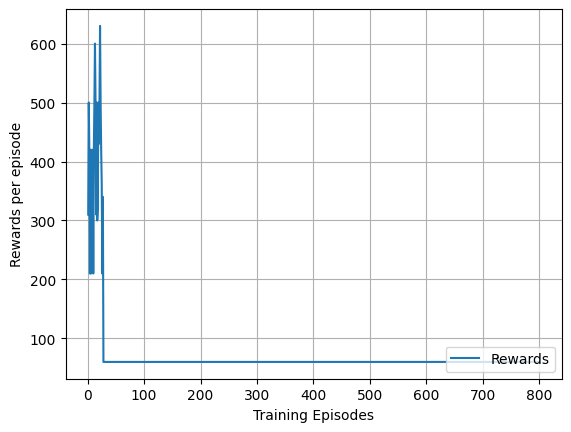

In [ ]:
# create the acrobot environment
env = gym.make('ALE/MsPacman-ram-v5', render_mode="rgb_array_list")

gamma = 0.99
hidden_sizes = (64, 64, 64)
actor_learning_rate = 0.003
critic_learning_rate = 0.003
replay_size = 1000000
minibatch_size = 4096
target_update = 8000
training_ep_per_eval = 5
warmup_target = 20000
target_entropy_ratio = 0.98
optim_time = 4
max_episodes = 1000
max_steps = 18000
criterion_episodes = 5

agent = SAC(env,
            gamma=gamma,
            hidden_sizes=hidden_sizes,
            actor_learning_rate=actor_learning_rate,
            critic_learning_rate=critic_learning_rate,
            replay_size=replay_size,
            minibatch_size=minibatch_size,
            target_update=target_update,
            training_ep_per_eval=training_ep_per_eval,
            warmup_target = warmup_target,
            target_entropy_ratio=target_entropy_ratio,
            optim_time=optim_time)


agent.train(max_episodes, lambda x : min(x) >= 1000, criterion_episodes)


In [ ]:
# visualise one episode
state, _ = env.reset()
terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated or steps > max_steps):
    # take action based on policy
    with torch.no_grad():
      action = agent.policy(state, stochastic=False)

    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    #print(f'Reward: {reward}')
    total_reward += reward
    steps += 1

print(f'Reward: {total_reward}')

# store RGB frames for the entire episode
frames = env.render()

# close the environment
env.close()

# create and play video clip using the frames and given fps
clip = mpy.ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

Reward: 60.0


## Reduce Buffer Size
1,000,000 to 500,000

 Training Episode 1000 done: steps = 533444, rewards = 70.0

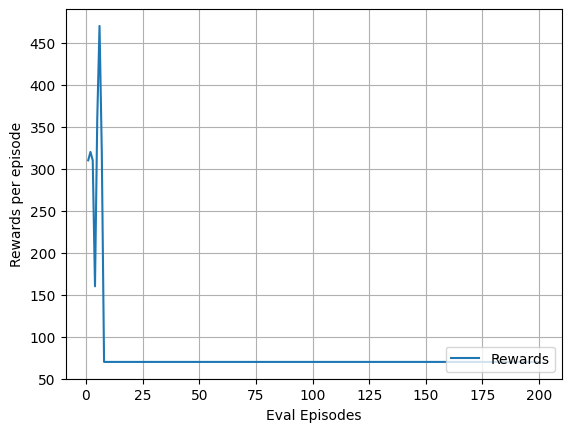

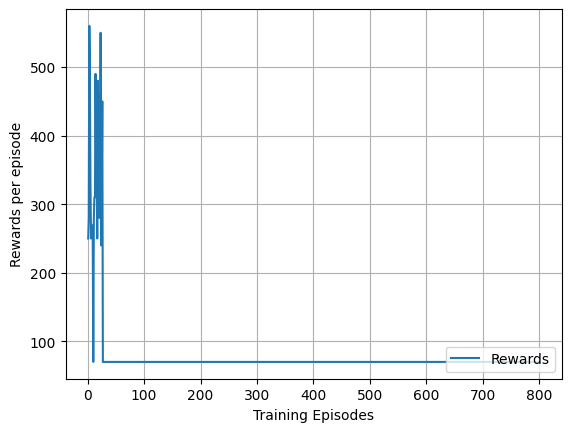

In [ ]:
# create the acrobot environment
env = gym.make('ALE/MsPacman-ram-v5', render_mode="rgb_array_list")

gamma = 0.99
hidden_sizes = (64, 64, 64)
actor_learning_rate = 0.003
critic_learning_rate = 0.003
replay_size = 500000
minibatch_size = 4096
target_update = 8000
training_ep_per_eval = 5
warmup_target = 20000
target_entropy_ratio = 0.98
optim_time = 4
max_episodes = 1000
max_steps = 18000
criterion_episodes = 5

agent = SAC(env,
            gamma=gamma,
            hidden_sizes=hidden_sizes,
            actor_learning_rate=actor_learning_rate,
            critic_learning_rate=critic_learning_rate,
            replay_size=replay_size,
            minibatch_size=minibatch_size,
            target_update=target_update,
            training_ep_per_eval=training_ep_per_eval,
            warmup_target = warmup_target,
            target_entropy_ratio=target_entropy_ratio,
            optim_time=optim_time)


agent.train(max_episodes, lambda x : min(x) >= 1000, criterion_episodes)


## Reduce Target Entropy Ratio

 Training Episode 1000 done: steps = 380606, rewards = 210.0

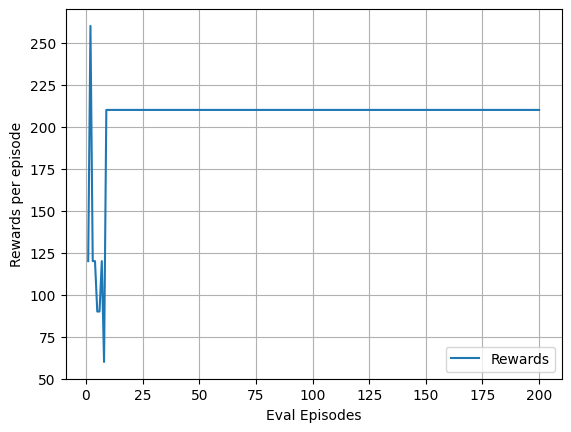

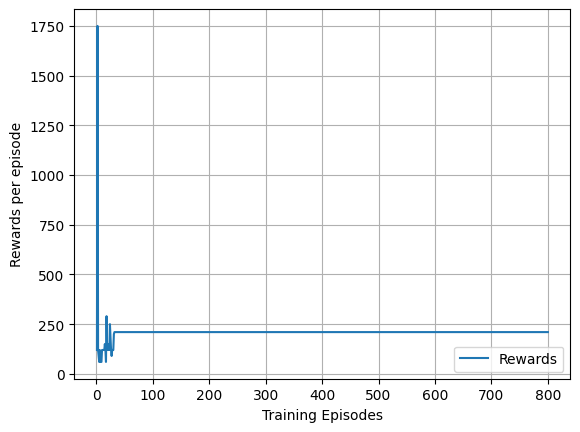

In [ ]:
# create the acrobot environment
env = gym.make('ALE/MsPacman-ram-v5', render_mode="rgb_array_list")

gamma = 0.99
hidden_sizes = (64, 64, 64)
actor_learning_rate = 0.003
critic_learning_rate = 0.003
replay_size = 500000
minibatch_size = 4096
target_update = 8000
training_ep_per_eval = 5
warmup_target = 20000
target_entropy_ratio = 0.5
optim_time = 4
max_episodes = 1000
max_steps = 18000
criterion_episodes = 5

agent = SAC(env,
            gamma=gamma,
            hidden_sizes=hidden_sizes,
            actor_learning_rate=actor_learning_rate,
            critic_learning_rate=critic_learning_rate,
            replay_size=replay_size,
            minibatch_size=minibatch_size,
            target_update=target_update,
            training_ep_per_eval=training_ep_per_eval,
            warmup_target = warmup_target,
            target_entropy_ratio=target_entropy_ratio,
            optim_time=optim_time)


agent.train(max_episodes, lambda x : min(x) >= 1000, criterion_episodes)


In [ ]:
# visualise one episode
state, _ = env.reset()
terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated or steps > max_steps):
    # take action based on policy
    with torch.no_grad():
      action = agent.policy(state, stochastic=False)

    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    #print(f'Reward: {reward}')
    total_reward += reward
    steps += 1

print(f'Reward: {total_reward}')

# store RGB frames for the entire episode
frames = env.render()

# close the environment
env.close()

# create and play video clip using the frames and given fps
clip = mpy.ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

Reward: 210.0
